# Quick Overview

This notebook provides a quick example of how to start using the `spectral_recovery` package. More detailed examples will soon become available in the [User Guide](https://people-er.github.io/Spectral-Recovery/about/).

If you want to try out the tool on your own, you can use the [test data on GitHub](https://github.com/PEOPLE-ER/Spectral-Recovery/tree/main/docs/test_data/test_data.zip).

Once the tool is installed with `pip install spectral-recovery`, you can import the package

In [2]:
import spectral_recovery as sr

## Defining a RestorationArea

To begin, we must create a `RestorationArea` object. This object holds and coordinates all the information necessary to compute recovery metrics for an area that has experienced disturbance and/or restoration. The following section briefly describes the input parameters but for more in-depth information, please see the [Spectral Recovery Tool](https://people-er.github.io/Spectral-Recovery/about/#2-the-spectral-recovery-tool) section in the User Guide.

### Input Parameters

| Name  | Type  | Description  |
|---|:---:|---|
| **restoration_polygon**  | geopandas.GeoDataFrame  | The spatial and temporal deliniation of the restoration event, i.e where disturance/restoration has occured with dates as attributes  |   
|  **reference_polygons** | geopandas.GeoDataFrame  | The spatial deliniation of the reference systems.  |   
|  **composite_stack** | xarray.DataArray  | The timeseries of annual composites for computing recovery metrics.   |  

### Prepping Inputs

#### Annual Composites

Next, read in your set of annual composites. To do this use the `read_and_stack_tifs` method. The method requires that you either provide a path to a directory containing all of your annual composites, or you provide a list of paths to each individual composite. Each composite:

1. _must_ be named after the year of which they are a composite, e.g for a composite of 2014 the file must be named `2014.tif`
2. _must_ have the bands named by their common names/acronyms

Each composite can contain multiple bands but each band must be present in all composites. 

The set of annual composites that we'll be using in this notebook was created using the [GEE BAP tool](https://github.com/saveriofrancini/bap).

In [3]:
import numpy as np

composite_stack = sr.read_timeseries(
    "test_data/annual_composites/landsat",
    band_names={1: "blue", 2: "green", 3: "red", 4: "nir", 5: "swir16", 6: "swir22"},
    array_type="numpy"
)
composite_stack = composite_stack.where(composite_stack != 0.0, np.nan)

#### Restoration Site (polygon and dates)

Read your restoration polygon using the `read_restoration_polygons` function. To fully define a restoration polygon, dates related to the disturbance and restoration start years must be provided. Optionally, reference start and end years can be provided, too. To provide these dates, you can:

1. Assign the dates in the polygon's attribute table using GIS software. Added attributes should be (str or int) the disturbance window start year, restoration window start year, reference start year, and reference end year. The years should be in the 1st, 2nd, 3rd, and 4th columns of the attribute table, respectively. The names of the columns do not matter, only the order.
2. Pass the dates (str or int) as arguments to the `read_restoration_polygons` function. 

NOTE: `read_restoration_polygons` is just a loose wrapper of `gpd.read_file` that also enforces the order of the date fields. If you want to handle the polygon your own way, feel free! Just remember that for future steps in the workflow to work, your polygon must be in a GeoDataFrame and the 1st, 2nd, 3rd, and 4th columns must be the disturbance start, restoration start, reference start (optional), and reference end (optional), respectively!

In [5]:
import geopandas as gpd

restoration_poly = sr.read_restoration_polygons(
    "test_data/wildfire_516.gpkg",
    disturbance_start="2005",
    restoration_start="2006",
    reference_start="2003",
    reference_end="2004",
)
restoration_poly

,dist_start,rest_start,ref_start,ref_end,geometry
0,2005,2006,2003,2004,"POLYGON ((493422.289 5967394.258, 493406.564 5..."


Text(0.5, 1.0, 'Test restoration polygon')

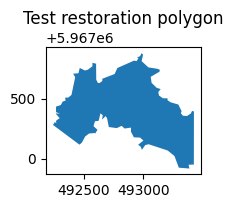

In [6]:
restoration_poly.plot(figsize=(2, 2)).set_title("Test restoration polygon")

### Computing Recovery Metrics

Now that we've prepped our input, we can create start computing recovery metrics.

A novel feature of the `spectral_recovery` package is that it allows users to choose between using a [historic recovery target](https://people-er.github.io/Spectral-Recovery/about/#14-recovery-targets) or a [reference recovery target](https://people-er.github.io/Spectral-Recovery/about/#14-recovery-targets) when computing recovery metrics. Be sure to consult the user guide and current literature when deciding which type of target works best for computing your recovery metrics.

#### Recovery Metrics with Median Recovery Target

A historical recovery target is computed using historic (prior to disturbance) values from the restoration site. Historic recovery targets can either be computed on the _pixel scale_, meaning that each pixel in the restoration site has a unique recovery target, or on the _polygon scale_, where the whole polygon has a single recovery target value. 

To compute recovery metrics using a median per-pixel recovery target, you only need to provide the restoration site and set the appopriate reference years.

In [7]:
# By default, the recovery targets are computed at the polygon scale.
ra_hist_polygon = sr.compute_metrics(
    timeseries_data=composite_stack,
    restoration_polygons=restoration_poly,
    metrics=["Y2R", "dNBR", "R80P", "YrYr"],
    indices=["NDVI", "NBR", "GNDVI"],
    timestep=4
)

In [8]:
# Parameterize a MedianTarget method for pixel scale.
per_pixel_method = sr.targets.MedianTarget(scale="pixel")

# To compute recovery targets at the pixel scale, pass the parameterized method.
recovery_metrics_pixel_target = sr.compute_metrics(
    timeseries_data=composite_stack,
    restoration_polygons=restoration_poly,
    metrics=["Y2R", "dNBR", "R80P", "YrYr"],
    indices=["NDVI", "NBR", "GNDVI"],
    recovery_target_method=per_pixel_method,
    timestep=4
)

You can visualize the spectral trajectory of your RestorationArea using the `plot_spectral_trajectory` function. If you want to write the plot to file, pass your desired path to the function.

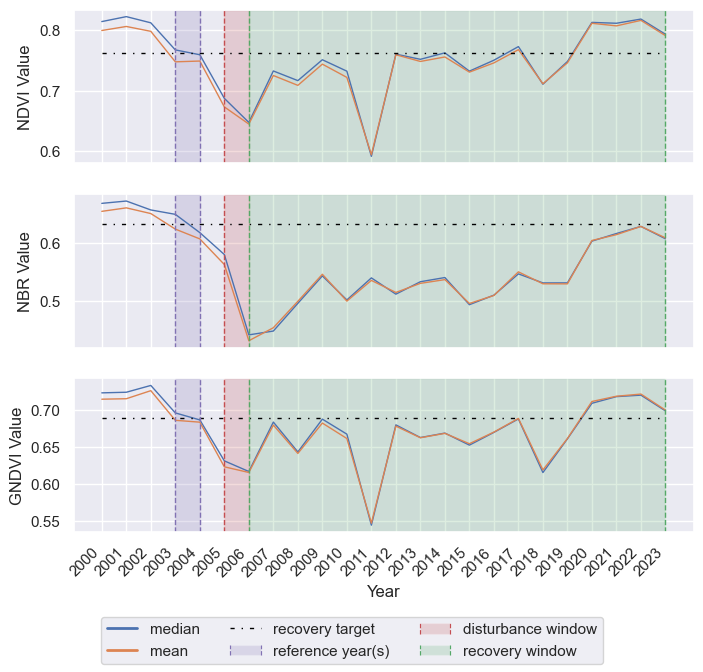

In [9]:
sr.plot_spectral_trajectory(
    timeseries_data=composite_stack,
    restoration_polygons=restoration_poly,
    indices=["NDVI", "NBR", "GNDVI"],
)
# or
# ra_hist.plot_spectral_trajectory("path/to/your_plot.png")

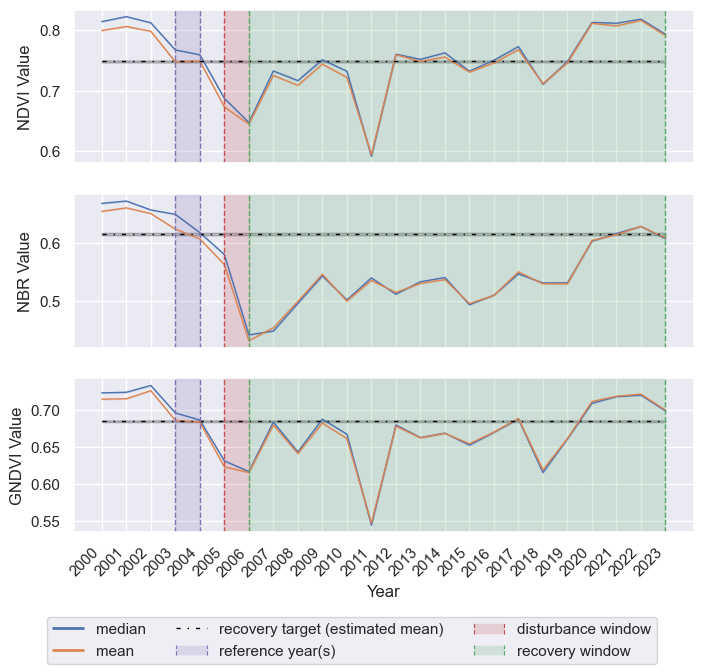

In [10]:
sr.plot_spectral_trajectory(
    timeseries_data=composite_stack,
    restoration_polygons=restoration_poly,
    indices=["NDVI", "NBR", "GNDVI"],
    recovery_target_method=per_pixel_method
)

#### Recovery metrics with Reference Recovery Target

A reference recovery target is computed using an area(s) in the same landscape as the restoration site that exhibits desirable, healthy, and stable ecosystem conditions (Gann et al., 2019). Reference areas can be composed of a single or multiple polygons. If the latter, the median of all individual polygon targets is taken to be the recovery target. All reference targets are a single value (i.e one value per-band), computed as the median across time and then space. To compute recovery metrics using reference recovery target, pass your reference site polygon(s) and dates to the `read_reference_polygons` functions. Similar to restoration polygons, the dates can either be in the vector file's attribute table or passed directly as arguments.

In [ ]:
reference_poly = sr.read_reference_polygons(
    "path/to/reference.gpkg",
    reference_start="2023",
    reference_end="2023"
)


ra_ref = sr.compute_metrics(
    restoration_polygon=restoration_poly,
    reference_polygon=reference_poly, # set this param to use a reference recovery target
    composite_stack=composite_stack,
    metrics=["Y2R", "dNBR", "R80P", "YrYr"],
    indices=["NDVI", "NBR", "GNDVI"],
    timestep=4
)

## Viewing Recovery Metrics

In [12]:
import matplotlib.pyplot as plt

def plot_metrics(metric):
    """ Plot the three bands in a single figure. """
    fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=[15, 4])
    for i in range(3):
        metric[0,i,:,:].plot(ax=axes[i])
        axes[i].set_title(f"{str(metric.metric.values[0])}: {metric['band'].values[i]}")
        axes[i].set_xlabel("X coordinate")
        if i == 0:
            axes[i].set_ylabel("Y coordinate")
        else:
            axes[i].set_ylabel("")
        plt.tight_layout()


Once you've computed your desired metrics, you can start visualization and analysis.

### Y2R

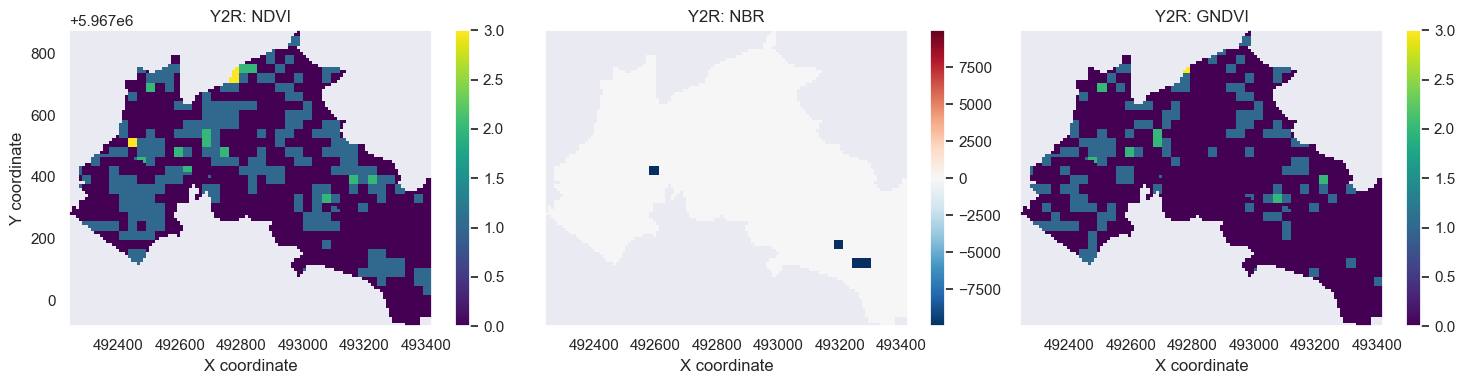

In [13]:
y2r = recovery_metrics_pixel_target.sel(metric=["Y2R"])
plot_metrics(y2r)

### R80P

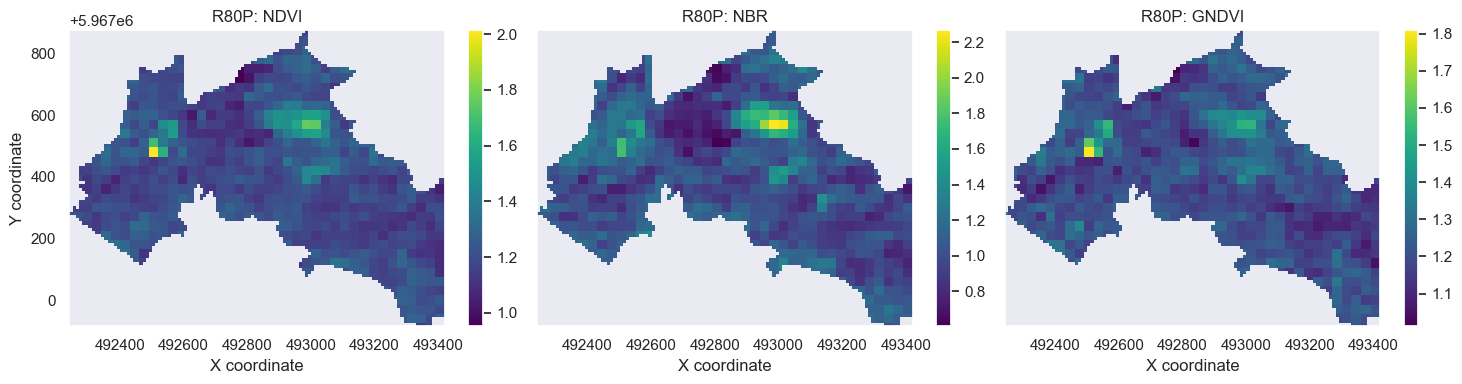

In [16]:
r80p = recovery_metrics_pixel_target.sel(metric=["R80P"])
plot_metrics(r80p)

### YrYr

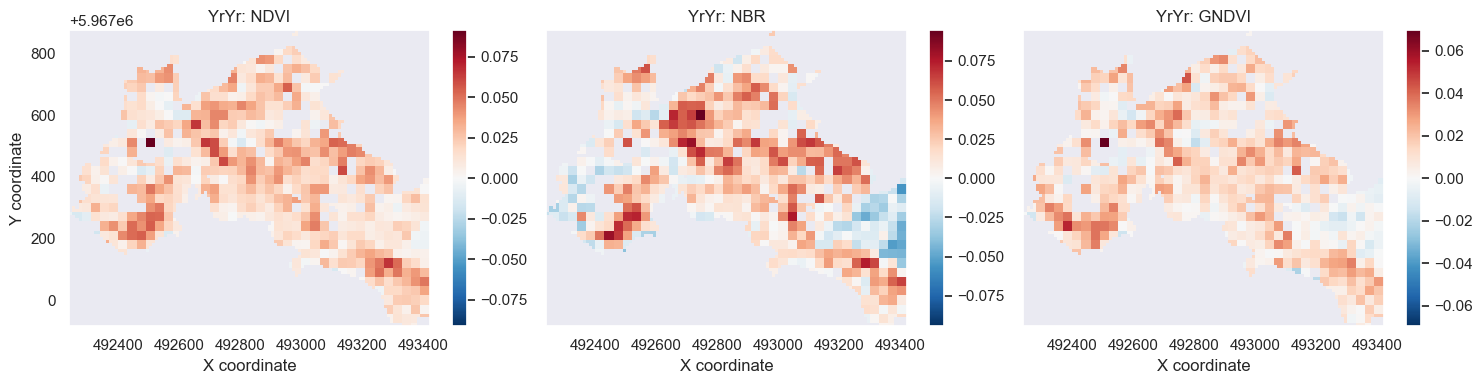

In [15]:
yryr = recovery_metrics_pixel_target.sel(metric=["YrYr"])
plot_metrics(yryr)

### dNBR

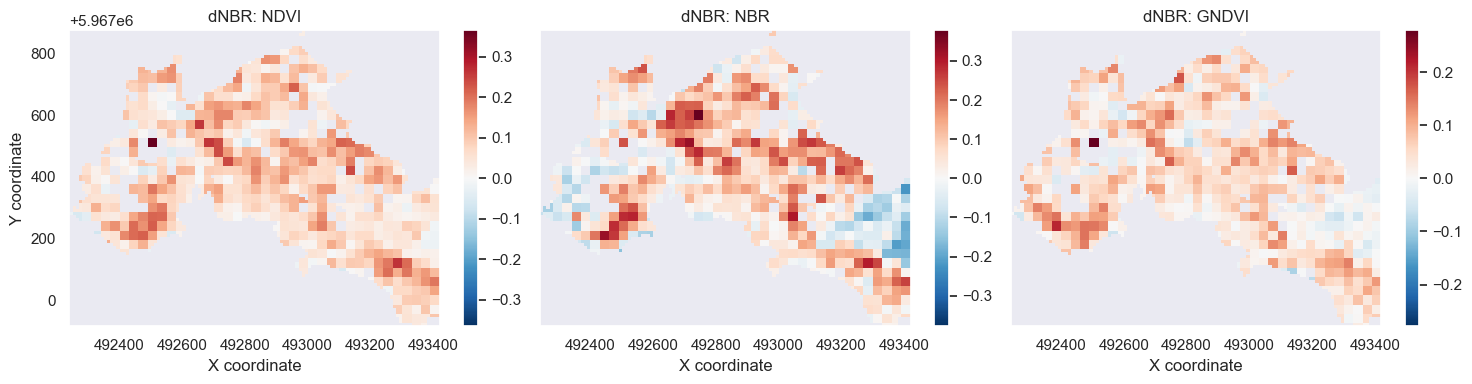

In [13]:
dNBR = recovery_metrics_pixel_target.sel(metric=["dNBR"])
plot_metrics(dNBR)

###  Writing Results

To write your metric results to raster files, the simpliest way is to use `rioxarray`'s `to_raster` function:


In [14]:
# write out y2r results to file:
y2r.sel(metric="Y2R").rio.to_raster("./y2r.tif")